<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/neural_lesson4/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [68]:
import torch
import pandas as pd
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

torch.manual_seed(0)

Дані про розпад протонів

[посилання](https://www.kaggle.com/datasets/fedesoriano/multijet-primary-dataset)

In [69]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/MultiJetRun2010B.csv')

df = df[df['nBJets'] != 2]

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані погано збалансовані

In [70]:
df['nBJets'].value_counts()

nBJets
0    20615
1     1056
Name: count, dtype: int64

In [71]:
df

,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,0.082072,0.0,0.000002,0.077191,0.041860,0.044618,0.342725,0.531326,0.480732,0.055588,0.696681,0.457241,0.440224,0.061659,0.043047,0.0,0
1,0.082072,0.0,0.000006,0.052182,0.055190,0.018690,0.493614,0.585784,0.491979,0.017684,0.567978,0.430552,0.474613,0.025133,0.034687,0.0,0
2,0.082072,0.0,0.000015,0.154156,0.035263,0.101251,0.540018,0.671386,0.470196,0.273968,0.533484,0.338381,0.325311,0.165718,0.059381,0.2,0
3,0.082072,0.0,0.000048,0.106599,0.123328,0.063472,0.306290,0.523352,0.483465,0.039306,0.713922,0.422854,0.493248,0.101707,0.108566,0.0,0
4,0.082072,0.0,0.000063,0.072599,0.024611,0.383563,0.508826,0.564737,0.292545,0.224039,0.550834,0.433906,0.361549,0.110721,0.018941,0.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21721,1.000000,1.0,0.999978,0.212416,0.025156,0.140492,0.463925,0.487819,0.523172,0.264163,0.621194,0.466781,0.329000,0.203114,0.118673,0.4,0
21722,1.000000,1.0,0.999990,0.127304,0.037219,0.070621,0.423669,0.700663,0.527521,0.061225,0.627277,0.300568,0.451816,0.108329,0.054421,0.0,0
21723,1.000000,1.0,0.999983,0.189029,0.001194,0.074007,0.380907,0.599091,0.522314,0.245323,0.676330,0.385055,0.338345,0.104850,0.008544,0.4,0
21724,1.000000,1.0,0.999999,0.077257,0.073102,0.292934,0.367161,0.500285,0.650965,0.189329,0.706220,0.464775,0.580432,0.068832,0.049297,0.0,0


Потрібно на основі інформації про розпад спрогнозувати наявність високоенергетичного випромінювання `nBJets`

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21671 entries, 0 to 21725
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     21671 non-null  float64
 1   Lumi    21671 non-null  float64
 2   Event   21671 non-null  float64
 3   MR      21671 non-null  float64
 4   Rsq     21671 non-null  float64
 5   E1      21671 non-null  float64
 6   Px1     21671 non-null  float64
 7   Py1     21671 non-null  float64
 8   Pz1     21671 non-null  float64
 9   E2      21671 non-null  float64
 10  Px2     21671 non-null  float64
 11  Py2     21671 non-null  float64
 12  Pz2     21671 non-null  float64
 13  HT      21671 non-null  float64
 14  MET     21671 non-null  float64
 15  nJets   21671 non-null  float64
 16  nBJets  21671 non-null  int64  
dtypes: float64(16), int64(1)
memory usage: 3.0 MB


# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [73]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['nBJets'])
y = df['nBJets']

dataset = MyDataset(X, y)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [75]:
from torch.utils.data import DataLoader

batch_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device='cuda') if device == "cuda" else torch.Generator()

train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, generator=generator)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, generator=generator)

# Завдання 3
Створіть нейромережу

In [76]:
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[4], output_size=1, activations=['sigmoid'], normalizations=None):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        self.activations = [self.get_activation(act) for act in activations]

        self.normalizations = normalizations

        for i in range(len(hidden_sizes) - 1):
            if normalizations and normalizations[i] is not None:
                self.layers.append(self.get_normalization(normalizations[i], hidden_sizes[i]))
            self.layers.append(self.activations[i])
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        if normalizations and normalizations[-1] is not None:
            self.layers.append(self.get_normalization(normalizations[-1], hidden_sizes[-1]))
        self.layers.append(self.activations[-1])
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.output_activation = nn.Sigmoid()

    def get_activation(self, activation):
        if activation == 'sigmoid':
            return nn.Sigmoid()
        elif activation == 'relu':
            return nn.ReLU()
        elif activation == 'leaky_relu':
            return nn.LeakyReLU()
        elif activation == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError("Unknown activation function")

    def get_normalization(self, norm, num_features):
        if norm == 'batch':
            return nn.BatchNorm1d(num_features)
        elif norm == 'layer':
            return nn.LayerNorm(num_features)
        else:
            raise ValueError("Unknown normalization type")

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_activation(x)

    def predict(self, x, device='cpu'):
        if isinstance(x, pd.DataFrame):
            x = torch.tensor(x.values, dtype=torch.float32)
        elif isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.to(device)
        self.to(device)
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x)
            y_pred = F.sigmoid(y_pred)

        return y_pred.cpu().numpy()

model = Model(input_size=16,
              hidden_sizes=[42, 21, 10, 5],
              output_size=1,
              activations=['relu', 'tanh', 'leaky_relu', 'relu', 'relu'],
              normalizations=['batch', None, 'layer', None, None])          # Замість None можна вказувати 'batch' для BatchNorm або 'layer' для LayerNorm

In [77]:
from torchsummary import summary

summary(model, input_size=(16,))

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       714
|    └─BatchNorm1d: 2-2                  84
|    └─ReLU: 2-3                         --
|    └─Linear: 2-4                       903
|    └─Tanh: 2-5                         --
|    └─Linear: 2-6                       220
|    └─LayerNorm: 2-7                    20
|    └─LeakyReLU: 2-8                    --
|    └─Linear: 2-9                       55
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      6
├─Sigmoid: 1-2                           --
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       714
|    └─BatchNorm1d: 2-2                  84
|    └─ReLU: 2-3                         --
|    └─Linear: 2-4                       903
|    └─Tanh: 2-5                         --
|    └─Linear: 2-6                       220
|    └─LayerNorm: 2-7                    20
|    └─LeakyReLU: 2-8                    --
|    └─Linear: 2-9                       55
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      6
├─Sigmoid: 1-2                           --
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [78]:
import time

from torch.optim import Adam, SGD, RMSprop
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau

class TrainingComponents:
    def __init__(self, model, y_train, loss_fn='BCEWithLogitsLoss', optimizer='Adam', scheduler='StepLR',
                 loss_params=None, opt_params=None, sched_params=None):

        self.model = model
        self.loss_fn = self.get_loss_fn(loss_fn, y_train, loss_params)
        self.optimizer = self.get_optimizer(optimizer, opt_params)
        self.scheduler = self.get_scheduler(scheduler, sched_params)

    def get_loss_fn(self, loss_fn, y_train, params):
        num0 = sum(y_train == 0)
        num1 = sum(y_train == 1)
        if loss_fn == 'BCEWithLogitsLoss':
            pos_weight = torch.tensor(num0 / num1)
            return nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        elif loss_fn == 'MSELoss':
            return nn.MSELoss(**(params if params else {}))
        elif loss_fn == 'CrossEntropyLoss':
            return nn.CrossEntropyLoss(**(params if params else {}))
        else:
            raise ValueError("Unknown loss function")

    def get_optimizer(self, optimizer, params):
        if optimizer == 'Adam':
            return Adam(self.model.parameters(), **(params if params else {'lr': 1e-3}))
        elif optimizer == 'SGD':
            return SGD(self.model.parameters(), **(params if params else {'lr': 1e-3, 'momentum': 0.9}))
        elif optimizer == 'RMSprop':
            return RMSprop(self.model.parameters(), **(params if params else {'lr': 1e-3}))
        else:
            raise ValueError("Unknown optimizer")

    def get_scheduler(self, scheduler, params):
        if scheduler == 'StepLR':
            return StepLR(self.optimizer, **(params if params else {'step_size': 5, 'gamma': 0.1}))
        elif scheduler == 'ExponentialLR':
            return ExponentialLR(self.optimizer, **(params if params else {'gamma': 0.9}))
        elif scheduler == 'ReduceLROnPlateau':
            return ReduceLROnPlateau(self.optimizer, **(params if params else {'mode': 'min', 'factor': 0.1, 'patience': 10}))
        else:
            raise ValueError("Unknown scheduler")


components = TrainingComponents(model=model,
                                y_train=y_train,
                                loss_fn='BCEWithLogitsLoss',
                                optimizer='Adam',
                                scheduler='StepLR',
                                loss_params=None,
                                opt_params={'lr': 1e-2, 'weight_decay': 0},
                                sched_params={'step_size': 5, 'gamma': 0.1})

In [79]:
loss_fn = components.loss_fn
optimizer = components.optimizer
scheduler = components.scheduler

# Завдання 5
Натренуйте нейромережу.

In [80]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, scheduler=None,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    if func == roc_auc_score:
                        # Check if there are both classes present in y
                        if len(np.unique(y)) == 2:
                            history_train[name] += func(y, y_pred) * x.size(0)
                    else:
                        history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        if func == roc_auc_score:
                            # Check if there are both classes present in y
                            if len(np.unique(y)) == 2:
                                history_val['val_' + name] += func(y, y_pred) * x.size(0)
                        else:
                            history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(history_val['val_loss'][-1])
            else:
                scheduler.step()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [81]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl, scheduler=scheduler,
                epochs=50,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary',
                log_interval=10)

Epoch    1    1sec	loss:       1.33	val_loss:       1.32	accuracy_score:      0.932	val_accuracy_score:      0.951	roc_auc_score:      0.502	val_roc_auc_score:       0.52	
Epoch   10    1sec	loss:       1.31	val_loss:       1.31	accuracy_score:      0.951	val_accuracy_score:      0.951	roc_auc_score:      0.583	val_roc_auc_score:      0.568	
Epoch   20    1sec	loss:       1.31	val_loss:       1.31	accuracy_score:      0.951	val_accuracy_score:      0.951	roc_auc_score:      0.593	val_roc_auc_score:      0.583	
Epoch   30    1sec	loss:       1.31	val_loss:       1.31	accuracy_score:      0.951	val_accuracy_score:      0.951	roc_auc_score:      0.587	val_roc_auc_score:      0.583	
Epoch   40    1sec	loss:       1.31	val_loss:       1.31	accuracy_score:      0.951	val_accuracy_score:      0.951	roc_auc_score:      0.597	val_roc_auc_score:      0.571	
Epoch   50    1sec	loss:       1.31	val_loss:       1.31	accuracy_score:      0.951	val_accuracy_score:      0.951	roc_auc_score:      0.591

# Завдання 6
Збережіть нейромережу та зробіть прогноз

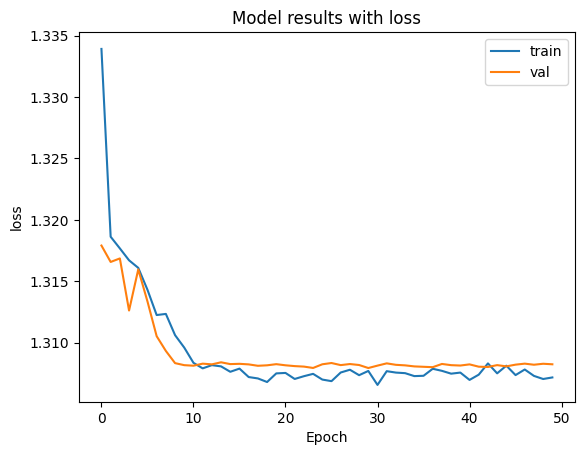

In [82]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

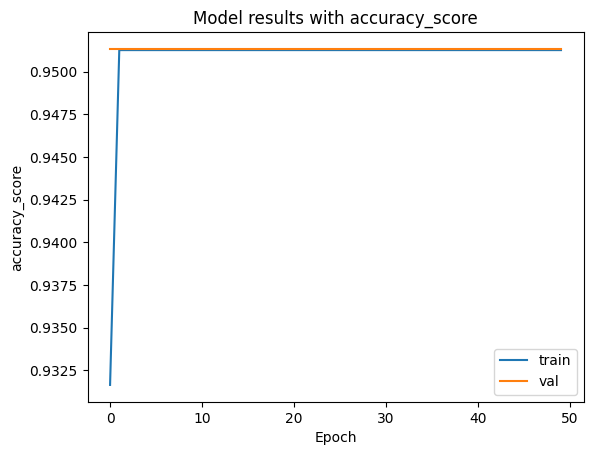

In [83]:
plot_metric(history, 'accuracy_score')

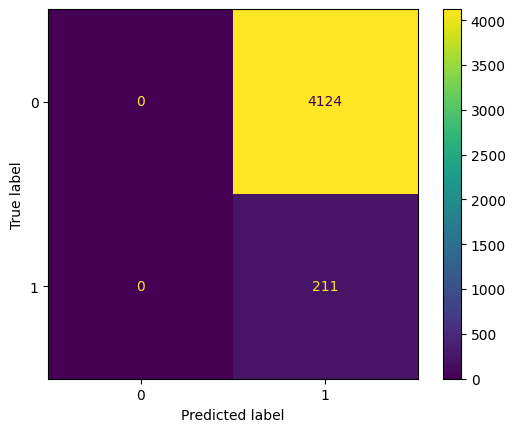

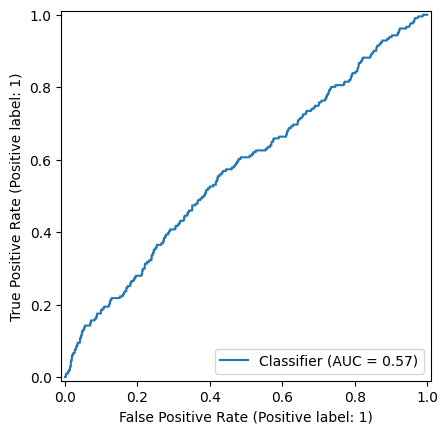

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')
y_pred = model.predict(X_test, device='cpu')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)